<a href="https://colab.research.google.com/github/gmoummi/DATA603Project/blob/master/DATA603_Project_Woldeeyesus_Moummi_Oppula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries 

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# GPU setup
import tensorflow as tf
import tensorflow.python.keras.backend as K

# GPUs and CPUs setup
config = tf.compat.v1.ConfigProto(device_count={'GPU': 2, 'CPU': 4})
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

Found GPU at: /device:GPU:0


Using TensorFlow backend.


In [ ]:
#import gdown: https://github.com/circulosmeos/gdown.pl
! pip install gdown
#import reviewContent.txt
! gdown "https://drive.google.com/uc?export=download&id=0B8JIKvhJUvRdUTBGaGlEZXhpWjg"
#import matadata.txt
! gdown "https://drive.google.com/uc?export=download&id=0B8JIKvhJUvRdc1BiZzdwcjdNRWM"
#import reviewDataset.csv
! gdown "https://drive.google.com/uc?export=download&id=1b9w5VfoaS4wTKCKqW2dAGbmwM1sMdsSM"

Downloading...
From: https://drive.google.com/uc?export=download&id=0B8JIKvhJUvRdUTBGaGlEZXhpWjg
To: /content/reviewContent
398MB [00:02, 152MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=0B8JIKvhJUvRdc1BiZzdwcjdNRWM
To: /content/metadata
17.2MB [00:00, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?export=download&id=1b9w5VfoaS4wTKCKqW2dAGbmwM1sMdsSM
To: /content/reviewDataset.csv
100% 212k/212k [00:00<00:00, 65.6MB/s]


In [ ]:
#### Reading training dataset from google drive


reviews = pd.read_table("reviewContent",names=["user_id","name","review_date","review"])
df_reviews = pd.DataFrame(reviews)

labels = pd.read_table("metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_labels = pd.DataFrame(labels)

In [ ]:
#### Data exploration

df_labels.head()

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28


In [ ]:
df_reviews.head()

,user_id,name,review_date,review
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...


In [ ]:
#### merging the reviews and business metadata and select columns we need for ML
combined = pd.concat([df_reviews,df_labels],axis=1,join="inner")

ML_dataset = combined[["label","review"]] 
ML_dataset.head()

,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [ ]:
### data exploration count of fake vs true reviews (-1= fake; 1= true) and identify if the data is balanced
ML_dataset.groupby(['label']).count()



,review
label,
-1,80461
1,527997


The dataset is unbalanced. The count of True reviews is almost 7 times higher than the count of fake reviews. To solve this problem and be able to train the machine learning algorithms, we have to balance the data set by replicating the fake reviews.

In [ ]:
duplicate1 = pd.concat([ML_dataset[ML_dataset["label"]==-1],ML_dataset],axis=0)
duplicate2 = pd.concat([ML_dataset[ML_dataset["label"]==-1],duplicate1],axis=0)
duplicate3 = pd.concat([ML_dataset[ML_dataset["label"]==-1],duplicate2],axis=0)
duplicate4 = pd.concat([ML_dataset[ML_dataset["label"]==-1],duplicate3],axis=0)
ML_df = pd.concat([ML_dataset[ML_dataset["label"]==-1],duplicate4],axis=0)

In [ ]:
#checking for null values
print('Checking for missing values:\n',ML_df.isna().sum())
print('Verify if data is balanced:\n',ML_df.groupby(['label']).count())

Checking for missing values:
 label     0
review    0
dtype: int64
Verify if data is balanced:
        review
label        
-1     482766
 1     527997


### Convolutional Neural Network

The embedding layer requires that **the input data be integer encoded**, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API or Onehotencoder provided with Keras.

Source: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#:~:text=The%20Embedding%20layer%20is%20initialized,used%20in%20another%20model%20later.


Overfitting is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data.

In [ ]:

from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

# a list contains each review as a list 
reviews_list = []
labels_list = []

for i in range(len(ML_dataset)):
    reviews_list.append(ML_dataset.iloc[i,1])
    labels_list.append(ML_dataset.iloc[i,0])


encoded_reviews = [one_hot(d, 10000) for d in reviews_list]

print(encoded_reviews)

max_length = 500
padded_reviews = pad_sequences(encoded_reviews, maxlen=max_length, padding='post')
print(padded_reviews)

# build model and add layers
cnn = Sequential()
cnn.add(Embedding(input_dim= 10000, output_dim= 200, input_length=500))
cnn.add(Dropout(0.5))
cnn.add(Conv1D(64, 5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=3))
#cnn.add(LSTM(200))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
cnn.summary()

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_reviews, np.array(labels_list), test_size=0.2)

# fitting the model to our data
history= cnn.fit(padded_reviews, np.array(labels_list), validation_split=0.2, batch_size=700, epochs=3)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[9530 2875 9226 ...    0    0    0]
 [4310 3577 8621 ...    0    0    0]
 [4310 6693 5743 ...    0    0    0]
 ...
 [7568 7100 4310 ...    0    0    0]
 [6753 2684 2348 ...    0    0    0]
 [ 868 7042 1836 ...    0    0    0]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 64)           64064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 165, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10560)             0         
________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 486766 samples, validate on 121692 samples
Epoch 1/3
486766/486766 [==============================] - 53s 109us/step - loss: 0.5650 - accuracy: 0.8664 - val_loss: 0.5773 - val_accuracy: 0.8685
Epoch 2/3
486766/486766 [==============================] - 47s 97us/step - loss: 0.5470 - accuracy: 0.8643 - val_loss: 0.5857 - val_accuracy: 0.8635
Epoch 3/3
486766/486766 [==============================] - 46s 95us/step - loss: 0.5123 - accuracy: 0.8326 - val_loss: 0.6108 - val_accuracy: 0.8049


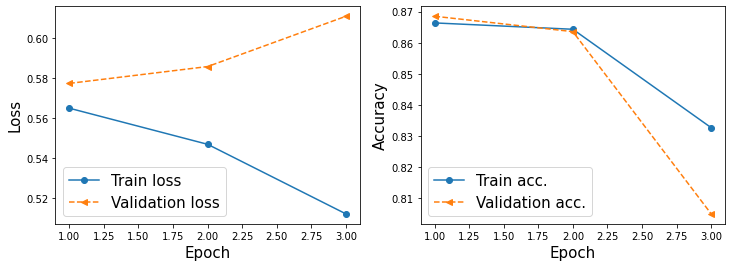

In [ ]:
#Plotting the loss and accuracy rate. This is supposed to show an increasing accuracy and decreasing loss.
#Source: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

### Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score


X= ML_dataset.iloc[:, 1].values
y= ML_dataset.iloc[:, 0].values


#splitting our dataset 80% train 20%test 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=1000)


# Vectorizer separates sentences and gives us a bag of words
#Source: https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


vectorizer = CountVectorizer(strip_accents= 'ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',lowercase=True, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#Naive Bayes Classifier
naive_bayes = MultinomialNB(alpha= 0.001)
naive_bayes.fit(X_train_vec, y_train)
predictions = naive_bayes.predict(X_test_vec)

#Predictions
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))


Accuracy score:  0.8034710580810571
Precision score:  0.8730202225023291
Recall score:  0.905165066196943


In [ ]:
###NB prediction and accuracy test on training set

predictions = naive_bayes.predict(X_train_vec)

#Predictions
print('Accuracy score: ', accuracy_score(y_train, predictions))
print('Precision score: ', precision_score(y_train, predictions))
print('Recall score: ', recall_score(y_train, predictions))

Accuracy score:  0.8449932821930867
Precision score:  0.8995557050102378
Recall score:  0.9246170126632623


### Support Vector Machine


In [ ]:
# fitting the balanced data to Support Vector Machine model

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import sklearn.metrics as metrics


#a list contains each review as a list 
svc_review = []
svc_labels = []

for i in range(len(ML_df)):
    svc_review.append(ML_df.iloc[i,1])
    svc_labels.append(ML_df.iloc[i,0])

#Term frequency; #count(word) / #Total words, in each document
#source: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=3) 
X_Vec = vectorizer.fit_transform(svc_review)
print(X_Vec.shape)

# split data into training and testing sets and fit the training set to the classifier

Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X_Vec, np.array(svc_labels), test_size=0.2)

svc_classifier = LinearSVC()
svc_classifier.fit(Xs_train, Ys_train)

#classifier prediction on our test set
svc_pred = svc_classifier.predict(Xs_test)

#classification report

print("Report for Support Vector Machine:")
print(classification_report(Ys_test, svc_pred))
print("Accuracy for test data lr % :",metrics.accuracy_score(Ys_test, svc_pred)*100)


(1010763, 2292341)
Report for Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.91      0.99      0.95     96577
           1       0.99      0.91      0.95    105576

    accuracy                           0.95    202153
   macro avg       0.95      0.95      0.95    202153
weighted avg       0.95      0.95      0.95    202153

Accuracy for test data lr % : 94.91325876934798


In [ ]:
##Prediction on training data

svc_pred_T = svc_classifier.predict(Xs_train)
print(classification_report(Ys_train, svc_pred_T))
print("Accuracy for training % :",metrics.accuracy_score(Ys_train, svc_pred_T)*100)

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99    386189
           1       1.00      0.99      0.99    422421

    accuracy                           0.99    808610
   macro avg       0.99      0.99      0.99    808610
weighted avg       0.99      0.99      0.99    808610

Accuracy for training % : 99.4434894448498


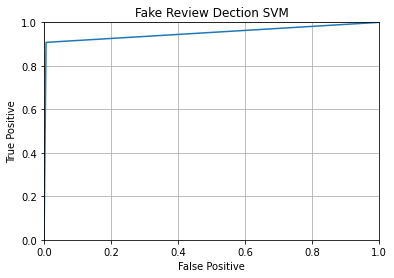

In [ ]:
#draw ROC curve SVM
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
fpr, tpr, thresholds = roc_curve(Ys_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Fake Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

## Importing Yelp dataset from yelp.com

#### At this point, we have trained our models, and concluded that SVM with a 95% accuracy is the best to detect fake reviews. We will apply this ML model on new Yelp reviews to distinguish between true and fake ones.

In [ ]:
# The dataset from Yelp.com loaded in to mongoDB and filtered data in python using pymongo library. 
## Filters are restaurant reviews for states(NC,AZ,PA,OH,NV)

yelp_reviews = pd.read_csv("reviewDataset.csv")


In [ ]:
# Data exploration
yelp_reviews.head()

,Unnamed: 0,business_id,date,review_id,sentence,stars,user_id
0,0,4sPB5HKm2-r_zOTIsyVpXQ,2018-02-23 23:26:58,5eeabed584f525043a4f0ef7,We will be back for the food for sure.,5.0,FTuP9fCw4zJXgI-1xSSjVg
1,1,5Q4Gw1pyZnG8IlFNozxIlw,2015-10-17 03:31:01,5eeabed684f525043a4f141b,I won't come back.,2.0,j9hC9EmCsS2S2ZtbsK-l0g
2,2,zhwqX2uk3XF_fwtwLj397A,2008-05-02 00:21:43,5eeabed684f525043a4f2365,"Other than the view, the only thing that stink...",4.0,XWXHE-0VRDzQIdEeMsY56Q
3,3,jGC-7KSSr4a6kceTehcSpA,2016-09-06 15:13:49,5eeabed684f525043a4f239c,"Needless to say, We will not be attending any ...",1.0,lD5wMO99KrL6z222YKBAoA
4,4,j5wcbhFqxEF-YtayK2fTjQ,2008-08-19 01:12:23,5eeabed684f525043a4f263e,This is a great lunch spot either for people w...,4.0,gru76BjkRY6UQVcw_yAxiQ


In [ ]:
text = yelp_reviews["sentence"]

def store_lst(text):
    text = text
    new_texts = []
    for i in range(len(text)):
        new_texts.append(text[i])
    return new_texts

new_texts = store_lst(text)

X = vectorizer.transform(new_texts)

#classifier predictions on the new dataframe (yelp reviews from yelp.com)
svc_predictions = svc_classifier.predict(X)

y_output = list(svc_predictions)
yp=["True" if a==1 else "Fake" for a in y_output]
Lp=[1 if a==1 else 0 for a in y_output]
X_outputlist = list(yelp_reviews["sentence"])
star = list(yelp_reviews["stars"])
user_id = list(yelp_reviews["user_id"])
business_id = list(yelp_reviews["business_id"])
labeledReviews = pd.DataFrame({"user_id":user_id, "business_id":business_id,"Stars":star,'Review':X_outputlist ,'True(1)/Fake(0)':yp,'Label':Lp})
labeledReviews

,user_id,business_id,Stars,Review,True(1)/Fake(0),Label
0,FTuP9fCw4zJXgI-1xSSjVg,4sPB5HKm2-r_zOTIsyVpXQ,5.0,We will be back for the food for sure.,True,1
1,j9hC9EmCsS2S2ZtbsK-l0g,5Q4Gw1pyZnG8IlFNozxIlw,2.0,I won't come back.,Fake,0
2,XWXHE-0VRDzQIdEeMsY56Q,zhwqX2uk3XF_fwtwLj397A,4.0,"Other than the view, the only thing that stink...",True,1
3,lD5wMO99KrL6z222YKBAoA,jGC-7KSSr4a6kceTehcSpA,1.0,"Needless to say, We will not be attending any ...",Fake,0
4,gru76BjkRY6UQVcw_yAxiQ,j5wcbhFqxEF-YtayK2fTjQ,4.0,This is a great lunch spot either for people w...,Fake,0
...,...,...,...,...,...,...
1249,Oay68SoCl5BcM4XAbt47zw,Fq4QY6qzRghqiS1OObxKGA,1.0,If you go here you're one of three types of pe...,Fake,0
1250,uWjyG1TP-Bb1b0eKJjLCjA,jN-rvhW1d5i-vDAgYkV98A,4.0,I plan going a couple more times before leavin...,True,1
1251,_ixvEpV363vm5cUW52FK7g,U8ypUjl42xwqh5ecQsbptw,4.0,Take a minute to read the history pages of the...,True,1
1252,W2xDhWqmkg5YOeaPakExZw,jN-rvhW1d5i-vDAgYkV98A,1.0,Overall I wouldn't come here if I'm extremely ...,True,1


### Data Visualization

In [ ]:
#Comparison of text length distribution in true vs fake reviews

num_words= []
for i in labeledReviews['Review']:
  res = len(i.split())
  num_words.append(res)
labeledReviews['review_length']= num_words
labeledReviews

,user_id,business_id,Stars,Review,True(1)/Fake(0),Label,review_length
0,FTuP9fCw4zJXgI-1xSSjVg,4sPB5HKm2-r_zOTIsyVpXQ,5.0,We will be back for the food for sure.,True,1,9
1,j9hC9EmCsS2S2ZtbsK-l0g,5Q4Gw1pyZnG8IlFNozxIlw,2.0,I won't come back.,Fake,0,4
2,XWXHE-0VRDzQIdEeMsY56Q,zhwqX2uk3XF_fwtwLj397A,4.0,"Other than the view, the only thing that stink...",True,1,72
3,lD5wMO99KrL6z222YKBAoA,jGC-7KSSr4a6kceTehcSpA,1.0,"Needless to say, We will not be attending any ...",Fake,0,30
4,gru76BjkRY6UQVcw_yAxiQ,j5wcbhFqxEF-YtayK2fTjQ,4.0,This is a great lunch spot either for people w...,Fake,0,28
...,...,...,...,...,...,...,...
1249,Oay68SoCl5BcM4XAbt47zw,Fq4QY6qzRghqiS1OObxKGA,1.0,If you go here you're one of three types of pe...,Fake,0,50
1250,uWjyG1TP-Bb1b0eKJjLCjA,jN-rvhW1d5i-vDAgYkV98A,4.0,I plan going a couple more times before leavin...,True,1,13
1251,_ixvEpV363vm5cUW52FK7g,U8ypUjl42xwqh5ecQsbptw,4.0,Take a minute to read the history pages of the...,True,1,11
1252,W2xDhWqmkg5YOeaPakExZw,jN-rvhW1d5i-vDAgYkV98A,1.0,Overall I wouldn't come here if I'm extremely ...,True,1,16


In [ ]:
labeledReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1254 non-null   object 
 1   business_id      1254 non-null   object 
 2   Stars            1254 non-null   float64
 3   Review           1254 non-null   object 
 4   True(1)/Fake(0)  1254 non-null   object 
 5   Label            1254 non-null   int64  
 6   review_length    1254 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 68.7+ KB


In [ ]:
#statistics summary for true reviews 
labeledReviews['review_length'][labeledReviews['True(1)/Fake(0)'] == 'True'].describe()

count    825.000000
mean      13.972121
std       12.241222
min        1.000000
25%        6.000000
50%       11.000000
75%       18.000000
max      133.000000
Name: review_length, dtype: float64

In [ ]:
#statistics summary for fake reviews
labeledReviews['review_length'][labeledReviews['True(1)/Fake(0)'] == 'Fake'].describe()

count    429.000000
mean      10.421911
std        9.817807
min        1.000000
25%        3.000000
50%        8.000000
75%       15.000000
max       76.000000
Name: review_length, dtype: float64

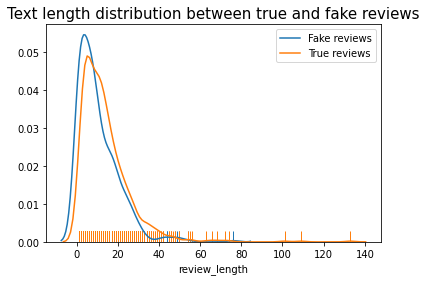

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#reviews length distribution for true vs. fake reviews
x1 = labeledReviews[labeledReviews['True(1)/Fake(0)']== 'Fake']['review_length']
x2 = labeledReviews[labeledReviews['True(1)/Fake(0)']== 'True']['review_length']
sns.distplot(x1, hist=False, rug=True, label= 'Fake reviews');
sns.distplot(x2, hist=False, rug=True, label= 'True reviews');
plt.title('Text length distribution between true and fake reviews', fontsize= 15)
plt.legend();

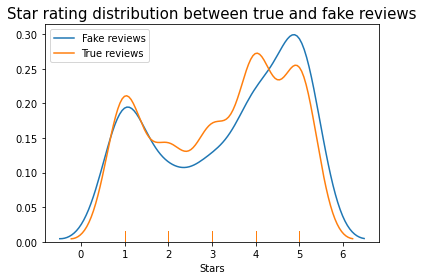

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#stars distribution for true vs. fake reviews
x1 = labeledReviews[labeledReviews['True(1)/Fake(0)']== 'Fake']['Stars']
x2 = labeledReviews[labeledReviews['True(1)/Fake(0)']== 'True']['Stars']
sns.distplot(x1, hist=False, rug=True, label= 'Fake reviews');
sns.distplot(x2, hist=False, rug=True, label= 'True reviews');
plt.title('Star rating distribution between true and fake reviews', fontsize= 15)
plt.legend();

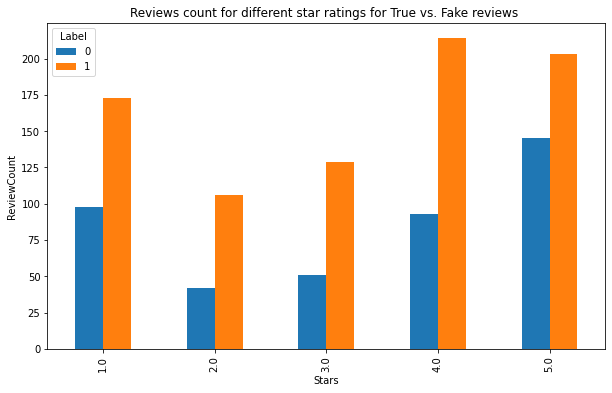

In [ ]:
### Star rating distribution with review count for fake Vs True
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Reviews count for different star ratings for True vs. Fake reviews ")
ax.set(xlabel = "Stars", ylabel = "ReviewCount")
labeledReviews.groupby('Stars').Label.value_counts().unstack().plot.bar(ax=ax)
plt.show()

In [ ]:
#### Identification of the most used words in true  vs. fake reviews

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

TrueReviews = labeledReviews.loc[labeledReviews['Label'] == 1]
FakeReviews = labeledReviews.loc[labeledReviews['Label'] == 0]

TrueReviews_text = " ".join(review for review in TrueReviews.Review)
print ("There are {} words in the combination of all true reviews.".format(len(TrueReviews_text)))

FakeReviews_text = " ".join(review for review in FakeReviews.Review)
print ("There are {} words in the combination of all fake reviews.".format(len(FakeReviews_text)))


There are 61540 words in the combination of all true reviews.
There are 24328 words in the combination of all fake reviews.


Below is the Word Cloud that gives overview of a word appearance frequency in the each of true and fake reviews at one glance. As the size of the text grows larger, the word is mentioned more frequent.

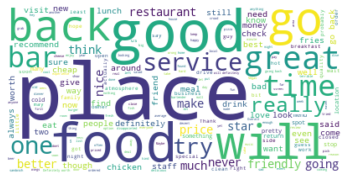

In [ ]:
# Word cloud for True reviews

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(TrueReviews_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

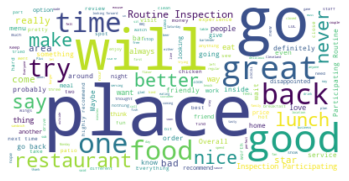

In [ ]:
# Word cloud for Fake reviews

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(FakeReviews_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In the above word clouds, we notice that there are few words that appear mostly in truthful reviews and there are few words that appear mostly in fake reviews. Unfortunately, there are few words that appear in the both.

##### Sources:
https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb

https://github.com/zzhang83/Yelp_Sentiment_Analysis/tree/master/Scripts

https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib

https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/

https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/

https://amueller.github.io/word_cloud/index.html

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
